# Thermal background from (1 - 2.5) µm

Nick Konidaris
31 March 2019

In [36]:
import numpy as np
%matplotlib inline
from pylab import *

import scipy.integrate
import scipy




from collections import namedtuple

import numpy as np
%matplotlib inline
from pylab import *

import astropy
from astropy import units as ur
from astropy import constants as cc
import astropy.modeling.blackbody

from astropy.convolution import convolve, Box1DKernel



hc = cc.h * cc.c
micron = ur.meter * 1e-6
K = ur.Kelvin




## Introduction

The thermal background of fiber irmos is computed.

Here I tabulate the Étendue of various systems preceeindg the fiber tip. These Etendues are useful because one can add them together and multiply by the blackbody spectral radiance to compute a thermal background for the instrument. Recall that for some spectral radiance $L_{e \Omega \lambda}$ in units of $\left[ Power/Bandwidth/Area/Solid\ angle \right]$ there is an Étendue ($G$) that will yield a Spectral flux $\Phi_e = L_{e \Omega \lambda} \cdot G$. 

Our goal with fiber IRMOS is to produce an instrument whose Étendue from the spectrograph is only a fraction of the Étendue from the telescope. So it is worth computing the Étendue of the telescope first. I use various approximations that are useful.

$\Omega \approx \pi \sin^2 \theta$ and this is equivalent to $\Omega \approx \frac{\pi}{(2\cdot f/\#)^2}$

$G_{telescope} = \Omega_{telescope} \cdot A_{telescope} \cdot \epsilon_{telescope} = 3.61E-6\cdot cm2\cdot sr$ (see below)


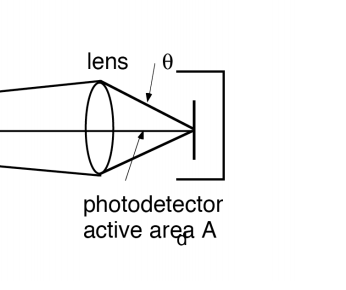

In [37]:
def theta_to_omega(half_angle_rad):
    # See figure above
    return np.pi * np.sin(half_angle_rad)**2 * ur.steradian

def fnum_to_omega(fnum):
    return np.pi /(2*fnum)**2 * ur.steradian

# ADC extinction

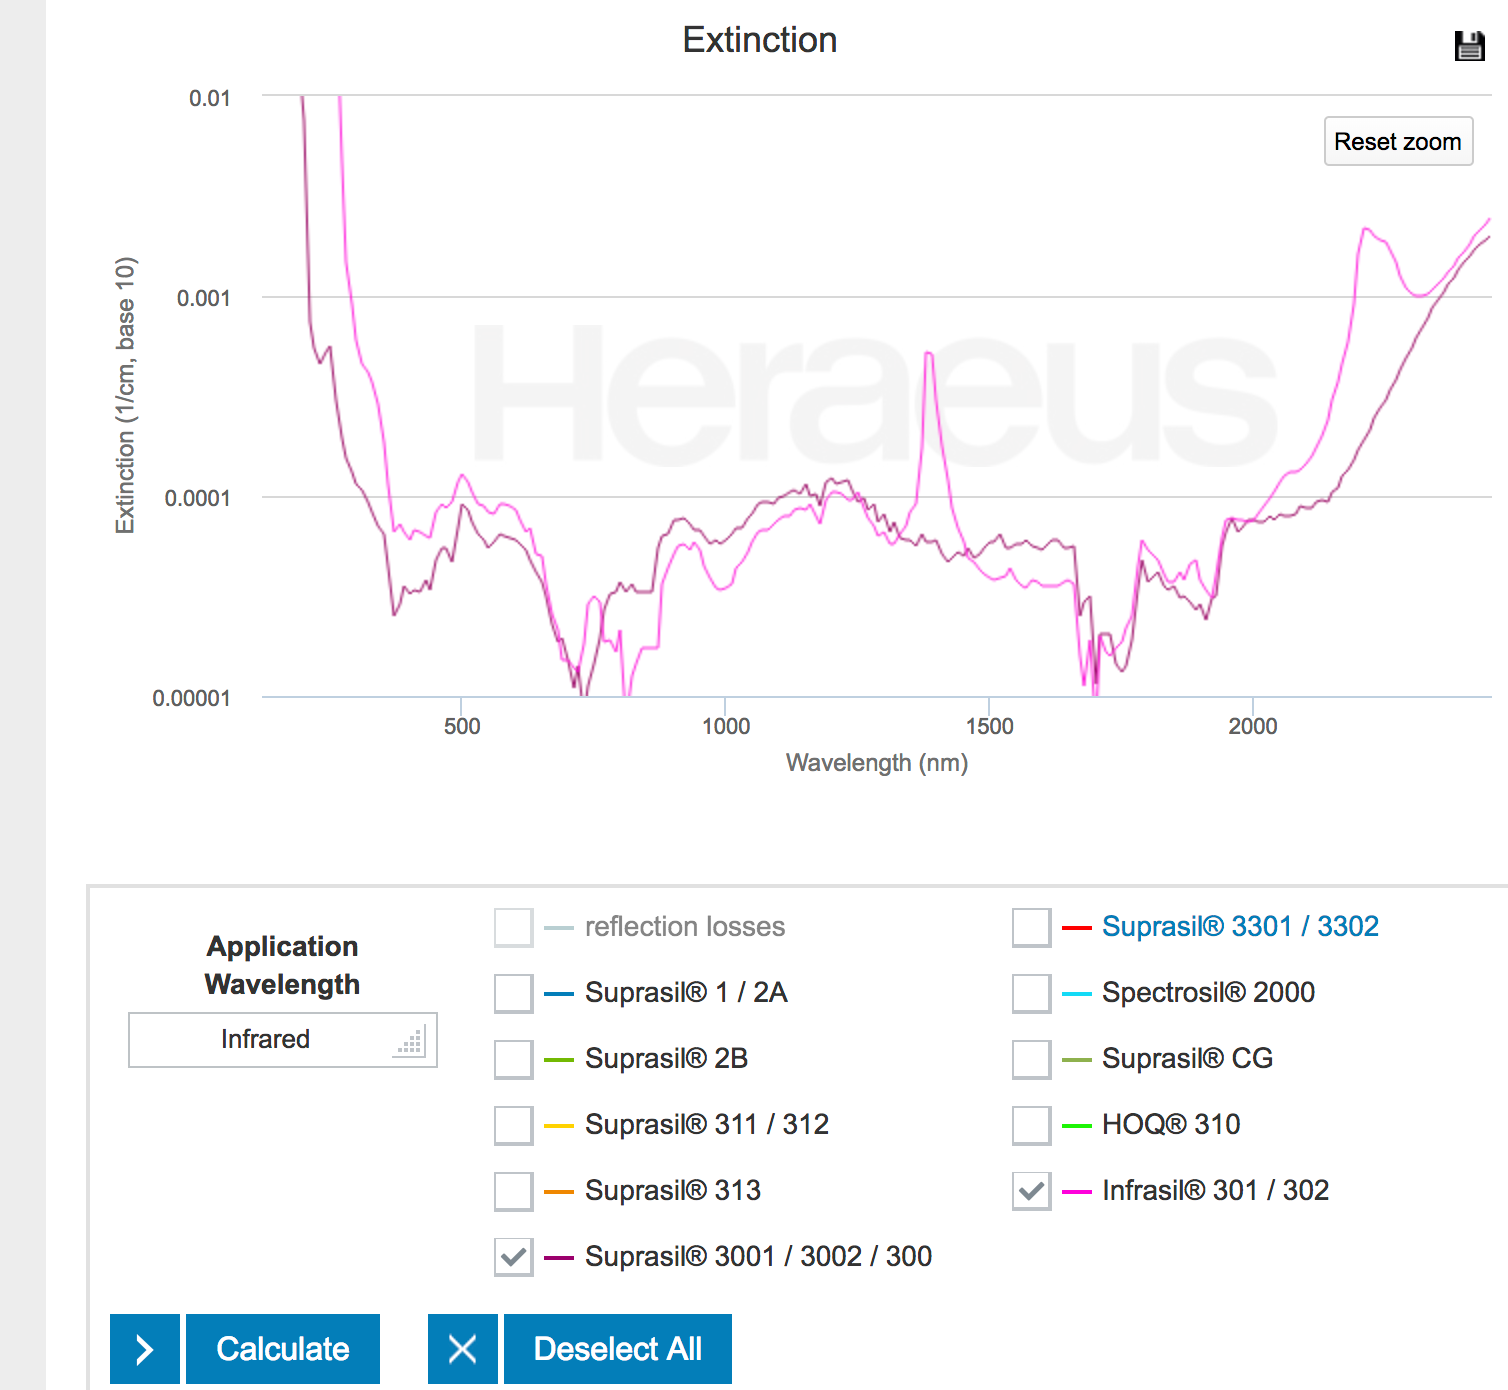

In [38]:
# Important constants


ϵ_world = 1

# Corrector
suprasil301transmissivity = 93.39/93.82


# TELESCOPE
Dtel = 6.5 * ur.meter
n_mirrors = 3
refl_mirror = .98
fnum_tel = 11


foot = 30.48*ur.cm
A_baffles = (pi*(3.25*foot)**2 - pi*(3*foot)**2).to(ur.cm**2) ## NUMBERS FROM SHEC DURING LUNCH

fnum_cam = 1.5
pixel_size= 18 * ur.micron
adc_thickness_cm = 10

#### DERIVED
Atel = (np.pi * (Dtel/2)**2).to(ur.cm**2)
A_pix = (pixel_size**2).to(ur.cm**2)
Asecondary = Atel * 0.074 # from http://www.lco.cl/telescopes-information/magellan/magellan-telescopes/#figure1
ϵ_tel = 1 - refl_mirror**n_mirrors
Gus = ur.micron**2 * ur.sr

platescale = (Dtel * fnum_cam/206265/ur.arcsec).to(ur.micron/ur.arcsec)
pixel_angle = pixel_size/platescale


# ADC
suprasil_200mm_trans = 10**(-adc_thickness_cm*0.001)
ϵ_adc = (1-suprasil_200mm_trans)


def p_h(varname):
    val = eval(varname)
    print("{0:25s} is {1:1.2e} or {2:3.0f}% of telescope".format(varname, val, val/G_telescope*100))

In [49]:
ϵ_adc

0.02276277904418933

# Telescope Grasp

In [50]:
# Note: am i being sloppy with square pixel and circular angles?

G_telescope2 = (theta_to_omega(pixel_angle/2) * Atel).to(Gus)
G_telescope =    (fnum_to_omega(fnum_cam) * A_pix).to(Gus)


p_h("G_telescope")
p_h("G_telescope2")

G_telescope               is 1.13e+02 micron2 sr or 100% of telescope
G_telescope2              is 8.88e+01 micron2 sr or  79% of telescope


# ADC Emissivity

In [51]:
G_adc = (fnum_to_omega(fnum_cam) * A_pix).to(Gus)

p_h("G_adc")

G_adc                     is 1.13e+02 micron2 sr or 100% of telescope


## Summary

In [52]:


vs = ["G_telescope", "G_adc"]


G_tot = 0
for ix,v in enumerate(vs):
    p_h(v)
    
    if ix > 0: G_tot += eval(v)

print()
p_h("G_tot")

G_telescope               is 1.13e+02 micron2 sr or 100% of telescope
G_adc                     is 1.13e+02 micron2 sr or 100% of telescope

G_tot                     is 1.13e+02 micron2 sr or 100% of telescope


# Load ATRAN Model

Use https://atran.arc.nasa.gov/cgi-bin/atran/atran.cgi

```
#       Input Parameters
# Observatory Altitude: 7400 feet
# Observatory Latitude: 39 degrees
# Water Vapor Overburden:       0 microns
# Std Atmosphere with : 5 Layers
# Zenith Angle: 30 degrees
# Wavelength Range:     1.5 - 2.5 microns
# Smoothing R:  0
#
#  Altitude    :    7400.00000
#  Water Vapor :    0.00000000
#  Num layers  :            5
#  Zenith Angle:    30.0000000
#  Obs Lat     :    39.0000000
#  Minimum Wave:    1.50000000
#  Maximum Wave:    2.50000000
#
#  The atmospheric model gives   6.7 Millimeters of water, toward the zenith.
#  The 'fine array' will be computed with sampling  each   1 elements.
#  Mean Sampling = 0.00000040 microns
#  Number of Points =    2504887
```



In [53]:
try:
    dat
except:
    dat = np.loadtxt("../K-band-background/atran/atran.plt.14451.dat.txt")

In [54]:
lams = dat[:,1] * ur.micron

goal = 2.4*ur.micron/3400
delt = lams[1]-lams[0]
N = np.int(np.ceil(goal/delt))
kernel = Box1DKernel(N)



lams = lams[::N]
ϵ_atm = (1 - convolve(dat[:,2], kernel))[::N]





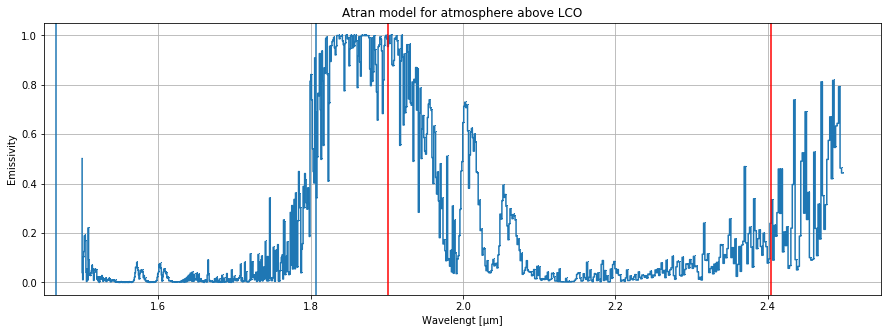

In [55]:
figure(figsize=(15,5))
step(lams, ϵ_atm,',')
axvline(2.404, color='red')
axvline(1.902, color='red')

axvline(1.807)
axvline(1.466)
grid(True)

title("Atran model for atmosphere above LCO")
xlabel("Wavelengt [µm]")
ylabel("Emissivity")

# Model

In [45]:
def model(lam, grasp, emissivity, efficiency=0.3, temp=300*K):
    """ Return BB curve for the reflective component of a telescope system
    
    Args:
        lam[] -- Wavelengths [L] to consider
        grasp -- Grasp of system in cm2 sr
        emissivity[] -- emissivity of system at that wavelength
        temp -- temperature
        
    Returns:
        Spectrum in units of 1/(s Angstrom) with same dimensionality as lam
     """
    epp = hc/lam

    # Specific spectral radiance in photon / sr/ m2 / bw
    L_e_Omega_lam = astropy.modeling.blackbody.blackbody_lambda(lam, temp)
        
    Phi_lam = L_e_Omega_lam * grasp * emissivity # Phi_lam is [Power]/[Bandwidth]
    N_lam = Phi_lam/epp # N_lam is [Hz]/[Bandwidth]
    
    nlam = N_lam.to(ur.Hertz/ur.angstrom) / (ur.Hertz/ur.angstrom) * efficiency
    flam = L_e_Omega_lam * (1*ur.arcsecond)**2 * emissivity * efficiency

    return nlam, flam.to(ur.erg/ur.second/ur.Angstrom/ur.cm**2)

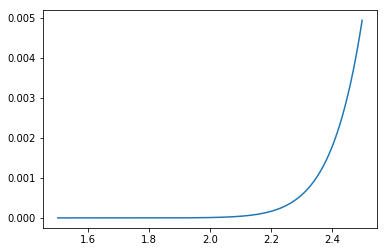

In [67]:
plot(lams, back_optics)

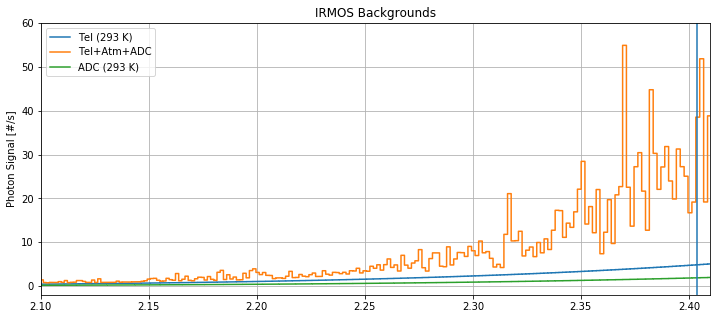

In [98]:
back_tel = model(lams, G_telescope, ϵ_tel, temp=293*ur.Kelvin)[0]
back_atm = model(lams, G_telescope, ϵ_atm)[0]
back_adc = model(lams, G_adc, ϵ_adc, temp=293*ur.Kelvin)[0]
back_optics = model(lams, G_telescope, .40, temp=120*ur.Kelvin)[0]


figure(figsize=(12,5))
S=np.sqrt
step(lams, back_tel)
step(lams, back_tel + back_atm + back_adc)
step(lams, back_adc)
#step(lams, back_optics)

#yscale("log")
xlim(2.1,2.41)
axvline(2.404)
ylim(-2,60)

ylabel("Photon Signal [#/s]")

legend(["Tel (293 K)", "Tel+Atm+ADC", "ADC (293 K)"])
title("IRMOS Backgrounds")
grid(True)

In [47]:
G_adc,G_telescope

(<Quantity 113.09733553 micron2 sr>, <Quantity 113.09733553 micron2 sr>)

In [48]:
astropy.modeling.blackbody.blackbody_lambda(500*ur.nm, 5000*ur.Kelvin)

<Quantity 1210716.7248379 erg / (Angstrom cm2 s sr)>

In [88]:
astropy.modeling.blackbody.blackbody_lambda(2400*ur.nm, 270*ur.Kelvin)/astropy.modeling.blackbody.blackbody_lambda(2400*ur.nm, 120*ur.Kelvin)

<Quantity 1.13107857e+12>